# User Data Analysis

This notebook analyzes all user energy consumption data files from the `data/user_data` directory to understand usage patterns and prepare for forecasting.

In [19]:
# Import Required Libraries
import pandas as pd
import numpy as np
import glob
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

In [27]:
# Load All User Data Files (Keep Separate)
def load_all_user_data(data_directory="../../../../data/user_data"):
    """
    Load all CSV files from the user_data directory into separate DataFrames
    Returns: dictionary with user_id as key and DataFrame as value
    """
    # Get all CSV files in the directory
    csv_files = glob.glob(f"{data_directory}/*.csv")
    
    print(f"Found {len(csv_files)} CSV files in {data_directory}")
    
    # Dictionary to store each user's DataFrame
    user_dataframes = {}
    file_info = []
    
    for file_path in csv_files:
        # Extract user ID from filename (assuming format: user_data_XXXX.csv)
        filename = os.path.basename(file_path)
        user_id = filename.replace('user_data_', '').replace('.csv', '')
        
        # Load the CSV file
        df = pd.read_csv(file_path)
        
        # Add metadata columns
        df['user_id'] = user_id
        df['source_file'] = filename
        
        # Store DataFrame in dictionary
        user_dataframes[user_id] = df
        
        # Store info about this file
        file_info.append({
            'user_id': user_id,
            'filename': filename,
            'rows': len(df),
            'columns': list(df.columns),
            'data_range': f"{df.iloc[0, 0] if len(df) > 0 else 'N/A'} to {df.iloc[-1, 0] if len(df) > 0 else 'N/A'}"
        })
        
    print(f"\nLoaded {len(user_dataframes)} user datasets")
        
    return user_dataframes, file_info

# Load the data
user_data_dict, file_info = load_all_user_data()

Found 146 CSV files in ../../../../data/user_data

Loaded 146 user datasets


In [21]:
# Display basic information about the loaded data
if user_data_dict:
    print("=== DATASET OVERVIEW ===")
    print(f"Number of users loaded: {len(user_data_dict)}")
    
    # Get first user's data for column inspection
    first_user_id = list(user_data_dict.keys())[0]
    first_df = user_data_dict[first_user_id]
    
    print(f"Sample user ID: {first_user_id}")
    print(f"Columns in each dataset: {list(first_df.columns)}")
    print(f"Data types:\n{first_df.dtypes}")
    
    print("\n=== SAMPLE DATA (First User) ===")
    display(first_df.head())
    
    print("\n=== FILE INFORMATION (First 5 Users) ===")
    for info in file_info[:5]:
        print(f"User {info['user_id']}: {info['rows']} rows, data range: {info['data_range']}")
    
    if len(file_info) > 5:
        print(f"... and {len(file_info) - 5} more users")
    
    print(f"\n=== DATASET SIZES ===")
    sizes = [len(df) for df in user_data_dict.values()]
    print(f"Min rows per user: {min(sizes)}")
    print(f"Max rows per user: {max(sizes)}")
    print(f"Average rows per user: {np.mean(sizes):.1f}")
    
else:
    print("No data was loaded. Please check the file path.")

=== DATASET OVERVIEW ===
Number of users loaded: 146
Sample user ID: 27665
Columns in each dataset: ['datetime', 'value', 'status', 'user_id', 'source_file']
Data types:
datetime        object
value          float64
status          object
user_id         object
source_file     object
dtype: object

=== SAMPLE DATA (First User) ===


datetime  value status user_id          source_file
0  2023-11-01 00:15:00  0.112      W   27665  user_data_27665.csv
1  2023-11-01 00:30:00  0.108      W   27665  user_data_27665.csv
2  2023-11-01 00:45:00  0.118      W   27665  user_data_27665.csv
3  2023-11-01 01:00:00  0.137      W   27665  user_data_27665.csv
4  2023-11-01 01:15:00  0.161      W   27665  user_data_27665.csv


=== FILE INFORMATION (First 5 Users) ===
User 27665: 35140 rows, data range: 2023-11-01 00:15:00 to 2024-11-01 00:00:00
User 35467: 35140 rows, data range: 2023-11-01 00:15:00 to 2024-11-01 00:00:00
User 9774: 35140 rows, data range: 2023-11-01 00:15:00 to 2024-11-01 00:00:00
User 37728: 35140 rows, data range: 2023-11-01 00:15:00 to 2024-11-01 00:00:00
User 89986: 35140 rows, data range: 2023-11-01 00:15:00 to 2024-11-01 00:00:00
... and 141 more users

=== DATASET SIZES ===
Min rows per user: 35140
Max rows per user: 35140
Average rows per user: 35140.0


# Data Visualization

Create a plot for each user to find out which user's data displays an actual households behavior

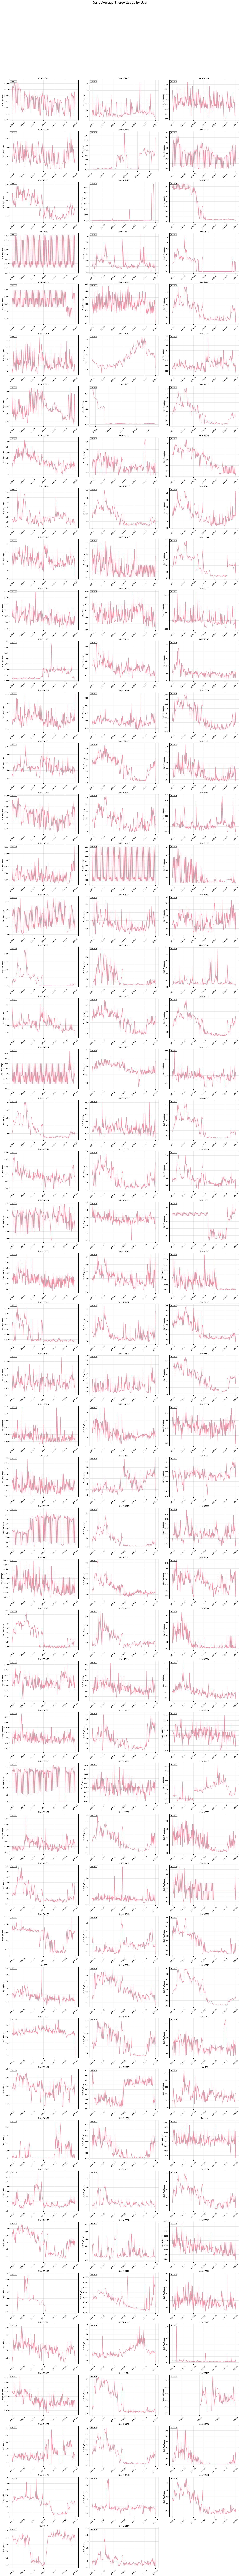

Generated plots for 146 users in 49 rows and 3 columns
Each plot shows daily average energy usage over time


In [22]:
# Create plots for all users with daily averages (3 plots per row)
if user_data_dict:
    import matplotlib.dates as mdates
    from datetime import datetime
    
    # Get list of users
    user_ids = list(user_data_dict.keys())
    n_users = len(user_ids)
    
    # Calculate grid dimensions (3 columns)
    n_cols = 3
    n_rows = (n_users + n_cols - 1) // n_cols  # Ceiling division
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
    fig.suptitle('Daily Average Energy Usage by User', fontsize=16, y=0.98)
    
    # Flatten axes array for easy iteration
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()
    
    # Plot each user's data
    for i, user_id in enumerate(user_ids):
        df = user_data_dict[user_id].copy()
        
        try:
            # Assume first column is datetime/timestamp
            datetime_col = df.columns[0]
            
            # Convert to datetime if not already
            df[datetime_col] = pd.to_datetime(df[datetime_col])
            
            # Set as index for resampling
            df.set_index(datetime_col, inplace=True)
            
            # Find the energy/usage column (typically numeric, not metadata)
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            usage_col = None
            
            # Look for common energy usage column names
            for col in numeric_cols:
                if any(keyword in col.lower() for keyword in ['usage', 'energy', 'consumption', 'kwh', 'power', 'load']):
                    usage_col = col
                    break
            
            # If no specific usage column found, use first numeric column
            if usage_col is None and len(numeric_cols) > 0:
                usage_col = numeric_cols[0]
            
            if usage_col is not None:
                # Resample to daily averages
                daily_avg = df[usage_col].resample('D').mean()
                
                # Plot on the appropriate subplot
                ax = axes[i]
                ax.plot(daily_avg.index, daily_avg.values, linewidth=1, alpha=0.8)
                ax.set_title(f'User {user_id}', fontsize=10)
                ax.set_ylabel('Daily Avg Usage', fontsize=8)
                ax.tick_params(axis='both', which='major', labelsize=8)
                
                # Format x-axis dates
                ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
                ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
                plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
                
                # Add grid for better readability
                ax.grid(True, alpha=0.3)
                
                # Add basic stats as text
                mean_usage = daily_avg.mean()
                ax.text(0.02, 0.98, f'Avg: {mean_usage:.1f}', 
                       transform=ax.transAxes, fontsize=8, 
                       verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
            
            else:
                # No usage column found
                axes[i].text(0.5, 0.5, f'User {user_id}\nNo usage data found', 
                           ha='center', va='center', transform=axes[i].transAxes)
                axes[i].set_title(f'User {user_id} - No Data', fontsize=10)
        
        except Exception as e:
            # Handle any errors in processing individual users
            axes[i].text(0.5, 0.5, f'User {user_id}\nError: {str(e)[:50]}...', 
                        ha='center', va='center', transform=axes[i].transAxes, fontsize=8)
            axes[i].set_title(f'User {user_id} - Error', fontsize=10)
    
    # Hide any unused subplots
    for j in range(n_users, len(axes)):
        axes[j].set_visible(False)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()
    
    print(f"Generated plots for {n_users} users in {n_rows} rows and {n_cols} columns")
    print("Each plot shows daily average energy usage over time")
    
else:
    print("No user data available for plotting. Please run the data loading cells first.")